# Week 1 — Polynomial & Interaction Terms

## A) Project context
In this Capstone I chose to use **FRED-MD**, a large monthly panel of U.S. macro indicators curated by McCracken & Ng (2015). It aggregates 130+ series across output, labor markets, housing, consumption, money/credit, interest & FX, prices, and equities, making it a standard starting point for macro forecasting and factor analysis.

## Why this dataset
FRED-MD is designed for reproducible, high-frequency macro research with clear preprocessing conventions (e.g., `tcode` transforms). Its breadth lets us test classical and modern models without hand-assembling data.

## Goal of Week 1
Establish a clean analysis base and explore **nonlinearities** via polynomial & interaction terms for predicting **monthly industrial production growth**.

**Target variable**: Δlog(INDPRO) (% m/m) — a high-frequency proxy for real activity that closely tracks the business cycle.

**This notebook (Week 1) will:**
1. Load & clean the panel (date index, numeric coercion, missingness handling).
2. Run quick EDA (target construction, basic plots, simple correlations).
3. Prepare a lean feature set for polynomial/interaction modeling (next step).


## B) Load & Clean

This section loads the FRED-MD CSV, standardizes the monthly DateTimeIndex, coerces numeric columns, removes fully-empty columns, and applies a light missingness policy to prepare a clean panel for EDA and modeling.


In [5]:
from pathlib import Path
import numpy as np, pandas as pd
import warnings; warnings.filterwarnings("ignore")

# --- Config ---
DATA_PATH = Path("./2025-09-MD.csv")   # adjust if your notebook sits elsewhere
MAX_NA_SHARE = 0.25                     # drop columns with >25% missing values
DATE_CANDIDATES = ["sasdate", "date", "DATE", "Month", "month"]

# --- Load ---
df_raw = pd.read_csv(DATA_PATH)
print("Loaded shape:", df_raw.shape)
print("Columns (first 10):", list(df_raw.columns[:10]))


Loaded shape: (801, 127)
Columns (first 10): ['sasdate', 'RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD']


In [7]:
# Identify a date-like column
date_col = next((c for c in DATE_CANDIDATES if c in df_raw.columns), None)
if date_col is None:
    raise ValueError(f"No date column found. Expected one of {DATE_CANDIDATES}.")

# Parse dates and set as index (normalize to month start)
df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce")
df_raw = df_raw.set_index(date_col).sort_index()
df_raw.index = df_raw.index.to_period("M").to_timestamp()  # month start

# Coerce non-date columns to numeric where possible
df = df_raw.copy()
for c in df.columns:
    if df[c].dtype == "O":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop duplicated timestamps and fully-empty columns
df = df.loc[~df.index.duplicated(keep="first")]
before_cols = df.shape[1]
df = df.dropna(axis=1, how="all")
print(f"Dropped {before_cols - df.shape[1]} fully-empty columns.")

print("Date range:", df.index.min().date(), "→", df.index.max().date())
print("Current shape:", df.shape)



Dropped 0 fully-empty columns.
Date range: 1959-01-01 → 2025-08-01
Current shape: (801, 126)


In [8]:
na_share = df.isna().mean().sort_values(ascending=False)
print("Top-15 columns by missingness:")
display(na_share.head(15))


Top-15 columns by missingness:


ACOGNO           0.496879
TWEXAFEGSMTHx    0.209738
UMCSENTx         0.192260
ANDENOx          0.136080
VIXCLSx          0.052434
PERMIT           0.014981
PERMITNE         0.014981
PERMITMW         0.014981
PERMITS          0.014981
PERMITW          0.014981
S&P div yield    0.002497
S&P PE ratio     0.001248
COMPAPFFx        0.001248
CP3Mx            0.001248
CMRMTSPLx        0.001248
dtype: float64

In [9]:
# Keep columns with acceptable NA share; then fill small gaps for continuity
keep_cols = [c for c in df.columns if df[c].isna().mean() <= MAX_NA_SHARE]
drop_cols = sorted(set(df.columns) - set(keep_cols))

df_clean = df[keep_cols].copy()
df_clean = df_clean.fillna(method="ffill").fillna(method="bfill")

print(f"Kept {len(keep_cols)} columns; dropped {len(drop_cols)} (> {int(MAX_NA_SHARE*100)}% NA).")
print("Clean panel shape:", df_clean.shape)
print("Example rows:")
display(df_clean.head(3))

# I save cleaned panel for reproducibility
df_clean.to_csv("fredmd_clean.csv", index=True)

Kept 125 columns; dropped 1 (> 25% NA).
Clean panel shape: (801, 125)
Example rows:


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,95.3,6476.0,12298.0,84.2043,19.5715
1959-02-01,2593.596,2434.8,15.346,278713.9773,17819.01912,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,95.3,6476.0,12298.0,83.5280,19.5715
1959-03-01,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,95.3,6508.0,12349.0,81.6405,19.5715


### Summary: Load & Clean (what I see in this dataset)

- **Raw file loaded:** shape `(801, 127)`.
- **Monthly index normalized:** `1959-01-01 → 2025-08-01`.
- **After removing fully-empty columns:** shape `(801, 126)`.
- **Missingness (top examples):**
  - `ACOGNO` (~49.7% NA), `TWEXAFE...x` (~21.0%), `UMCSENTx` (~19.2%), `ANDENOx` (~13.6%), `VIXCL...x` (~5.2%), several regional permit series (~1.5% each).
- **Light cleaning policy applied:** dropped **1** column with >25% NA; forward/back-filled small gaps for the rest.
- **Cleaned panel:** shape `(801, 125)` saved as **`fredmd_clean.csv`**.

This gives me a stable monthly panel to proceed with EDA. In the next step I’ll construct the target **Δlog(INDPRO) (% m/m)**, visualize it, and inspect simple co-movements with a few canonical drivers (rates, labor, prices).


## C) Exploratory Data Analysis (EDA)

In this section I want to get a first feel for the dataset.  
I'll start by loading the cleaned FRED-MD panel I created earlier, then construct my target variable — the monthly percentage change in industrial production (Δlog(INDPRO) × 100).  
After that, I’ll visualize this target, compare it to a few macro drivers, and look at basic correlations to understand what tends to move together.


In [11]:
# I load the cleaned dataset I saved in the previous step.
# Having it saved separately allows me to restart from here if needed.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11,4)
plt.rcParams["axes.grid"] = True

df_clean = pd.read_csv("fredmd_clean.csv", index_col=0, parse_dates=True)
print("Loaded cleaned panel:", df_clean.shape)
df_clean.head(3)


Loaded cleaned panel: (801, 125)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,95.3,6476.0,12298.0,84.2043,19.5715
1959-02-01,2593.596,2434.8,15.346,278713.9773,17819.01912,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,95.3,6476.0,12298.0,83.5280,19.5715
1959-03-01,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,95.3,6508.0,12349.0,81.6405,19.5715


In [31]:
# Before diving into transformations, I list all available variables in the cleaned FRED-MD panel.
# This helps me keep an overview of the dataset structure and choose which variables to focus on later.

all_features = df_clean.columns.tolist()
print(f"The cleaned dataset contains {len(all_features)} columns.\n")



for i, col in enumerate(all_features, 1):
     print(f"{i:>3}. {col}")


The cleaned dataset contains 125 columns.

  1. RPI
  2. W875RX1
  3. DPCERA3M086SBEA
  4. CMRMTSPLx
  5. RETAILx
  6. INDPRO
  7. IPFPNSS
  8. IPFINAL
  9. IPCONGD
 10. IPDCONGD
 11. IPNCONGD
 12. IPBUSEQ
 13. IPMAT
 14. IPDMAT
 15. IPNMAT
 16. IPMANSICS
 17. IPB51222S
 18. IPFUELS
 19. CUMFNS
 20. HWI
 21. HWIURATIO
 22. CLF16OV
 23. CE16OV
 24. UNRATE
 25. UEMPMEAN
 26. UEMPLT5
 27. UEMP5TO14
 28. UEMP15OV
 29. UEMP15T26
 30. UEMP27OV
 31. CLAIMSx
 32. PAYEMS
 33. USGOOD
 34. CES1021000001
 35. USCONS
 36. MANEMP
 37. DMANEMP
 38. NDMANEMP
 39. SRVPRD
 40. USTPU
 41. USWTRADE
 42. USTRADE
 43. USFIRE
 44. USGOVT
 45. CES0600000007
 46. AWOTMAN
 47. AWHMAN
 48. HOUST
 49. HOUSTNE
 50. HOUSTMW
 51. HOUSTS
 52. HOUSTW
 53. PERMIT
 54. PERMITNE
 55. PERMITMW
 56. PERMITS
 57. PERMITW
 58. AMDMNOx
 59. ANDENOx
 60. AMDMUOx
 61. BUSINVx
 62. ISRATIOx
 63. M1SL
 64. M2SL
 65. M2REAL
 66. BOGMBASE
 67. TOTRESNS
 68. NONBORRES
 69. BUSLOANS
 70. REALLN
 71. NONREVSL
 72. CONSPI
 73. S&P 500


## Understanding the main features

The FRED-MD dataset includes more than 120 monthly macroeconomic time series that together describe broad aspects of the U.S. economy.  
They are grouped by topic such as **Output and Income**, **Labor Market**, **Housing**, **Consumption**, **Money and Credit**, **Interest Rates**, **Prices**, and **Stock Market**.

Below are a few of the most important and frequently used variables:

| Variable | Description | Economic meaning |
|-----------|--------------|------------------|
| **INDPRO** | Industrial Production Index | Tracks real output across manufacturing, mining, and utilities — serves as a high-frequency proxy for GDP. |
| **UNRATE** | Civilian Unemployment Rate | Measures labor-market slack and overall economic health. |
| **PAYEMS** | Nonfarm Payroll Employment | Indicates the number of jobs in the economy, a strong coincident indicator of output. |
| **CPIAUCSL** | Consumer Price Index, All Urban Consumers | Captures inflation pressures faced by households. |
| **FEDFUNDS** | Effective Federal Funds Rate | The key short-term interest rate set by the Federal Reserve. |
| **GS10** | 10-Year Treasury Yield | Long-term interest rate reflecting expectations of growth and inflation. |
| **M2SL** | M2 Money Stock | Broad monetary aggregate capturing liquidity in the system. |
| **RETAILx** | Real Retail and Food Services Sales | Proxy for consumer spending and aggregate demand. |
| **SP500** | S&P 500 Stock Price Index | Reflects market sentiment and financial conditions. |
| **OILPRICEx** | Real Crude Oil Price | Affects input costs and consumer prices, linking energy markets to macro activity. |

These variables are central to macroeconomic modeling and policy analysis, and they will reappear frequently in the following weeks.  
They also provide an intuitive starting point for building models to predict **industrial production growth**, since each relates in some way to business-cycle dynamics.


In [12]:
# I define my target variable as the month-over-month percentage change in Industrial Production.
# This is a standard transformation in macro work and gives me a smoother, stationary-like series.

if "INDPRO" not in df_clean.columns:
    raise ValueError("Column 'INDPRO' not found in dataset.")

y = np.log(df_clean["INDPRO"]).diff() * 100   # Δlog × 100 → % m/m
y.name = "indpro_g_mom_pct"

# Align features to the same index (minus first NA)
X = df_clean.drop(columns=["INDPRO"], errors="ignore").loc[y.index]
y = y.dropna()
X = X.loc[y.index]

print("Target span:", y.index.min().date(), "→", y.index.max().date())
print("Number of monthly observations:", len(y))


Target span: 1959-02-01 → 2025-08-01
Number of monthly observations: 800


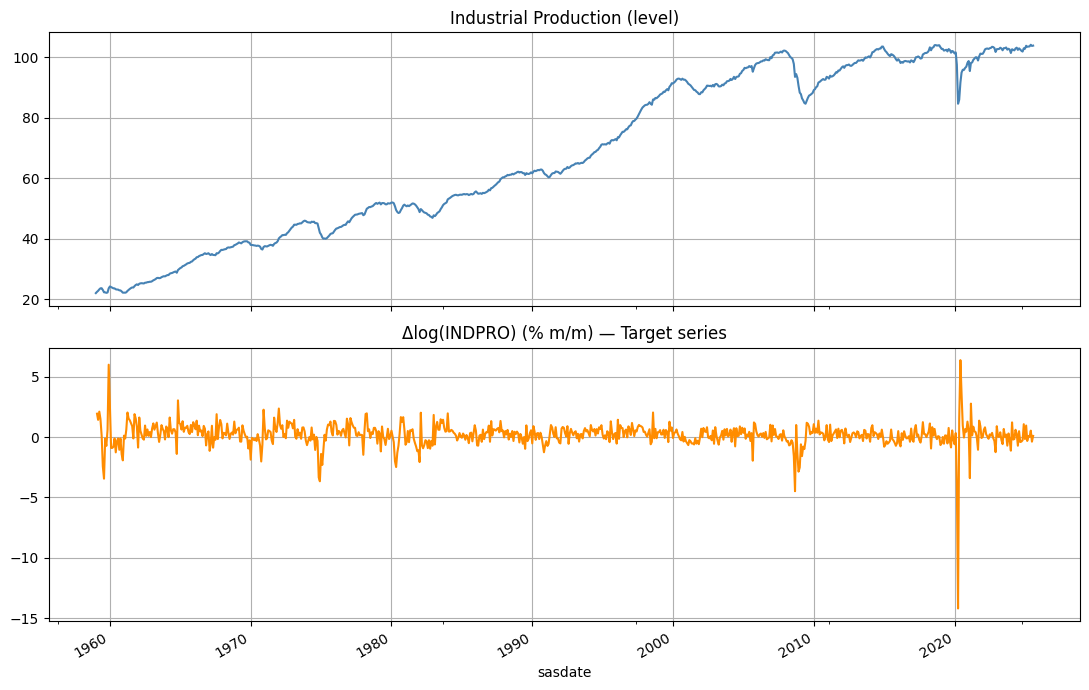

In [13]:
# I plot both the level of INDPRO and its monthly growth rate.
# This helps me see long-term trends and short-term volatility.

fig, ax = plt.subplots(2, 1, figsize=(11,7), sharex=True)
df_clean["INDPRO"].plot(ax=ax[0], color="steelblue")
ax[0].set_title("Industrial Production (level)")

y.plot(ax=ax[1], color="darkorange")
ax[1].set_title("Δlog(INDPRO) (% m/m) — Target series")
plt.tight_layout()
plt.show()


Drivers found: ['UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'GS10', 'PAYEMS', 'RETAILx']


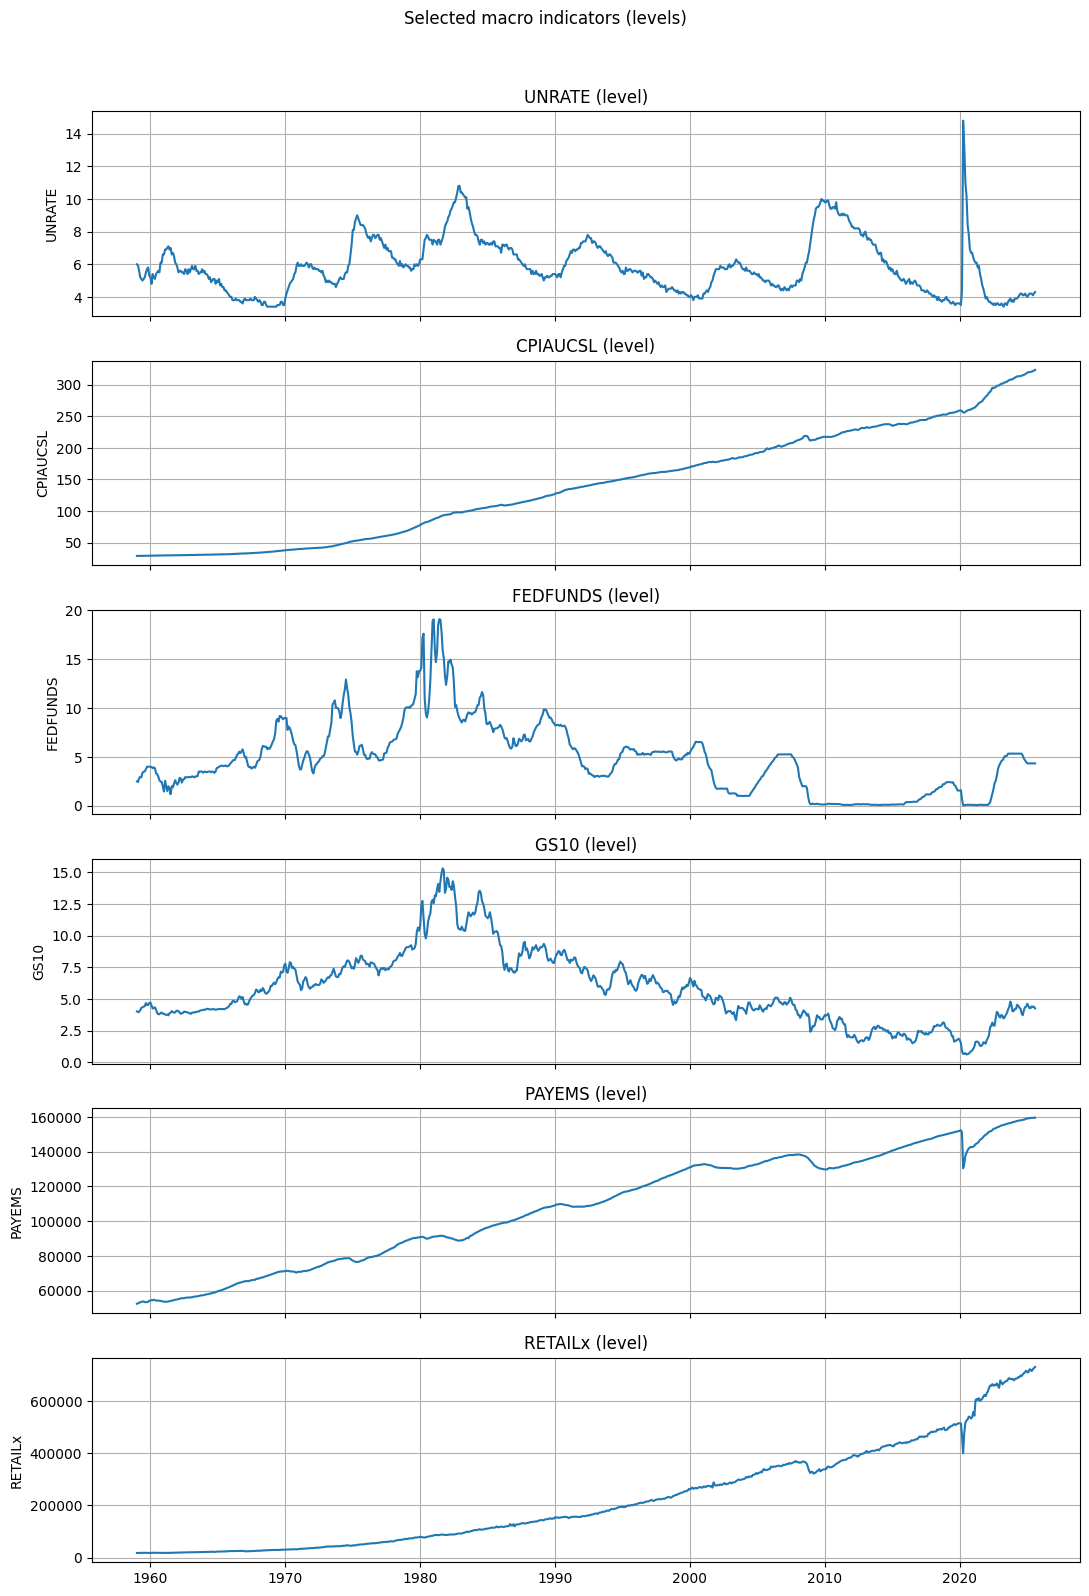

In [19]:
# I plot a small set of classic macro drivers (levels), with a clear title on each subplot.

import matplotlib.pyplot as plt

drivers  = ["UNRATE", "CPIAUCSL", "FEDFUNDS", "GS10", "PAYEMS", "RETAILx"]
existing = [d for d in drivers if d in df_clean.columns]
print("Drivers found:", existing)

if len(existing) == 0:
    print("No selected driver columns were found in the dataset.")
else:
    fig, axes = plt.subplots(len(existing), 1, figsize=(11, 2.6*len(existing)), sharex=True)
    if len(existing) == 1:
        axes = [axes]  # ensure iterable

    for ax, col in zip(axes, existing):
        ax.plot(df_clean.index, df_clean[col])
        ax.set_title(f"{col} (level)")
        ax.set_ylabel(col)

    fig.suptitle("Selected macro indicators (levels)", y=1.02)
    plt.tight_layout()
    plt.show()


Drivers found: ['UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'GS10', 'PAYEMS', 'RETAILx']


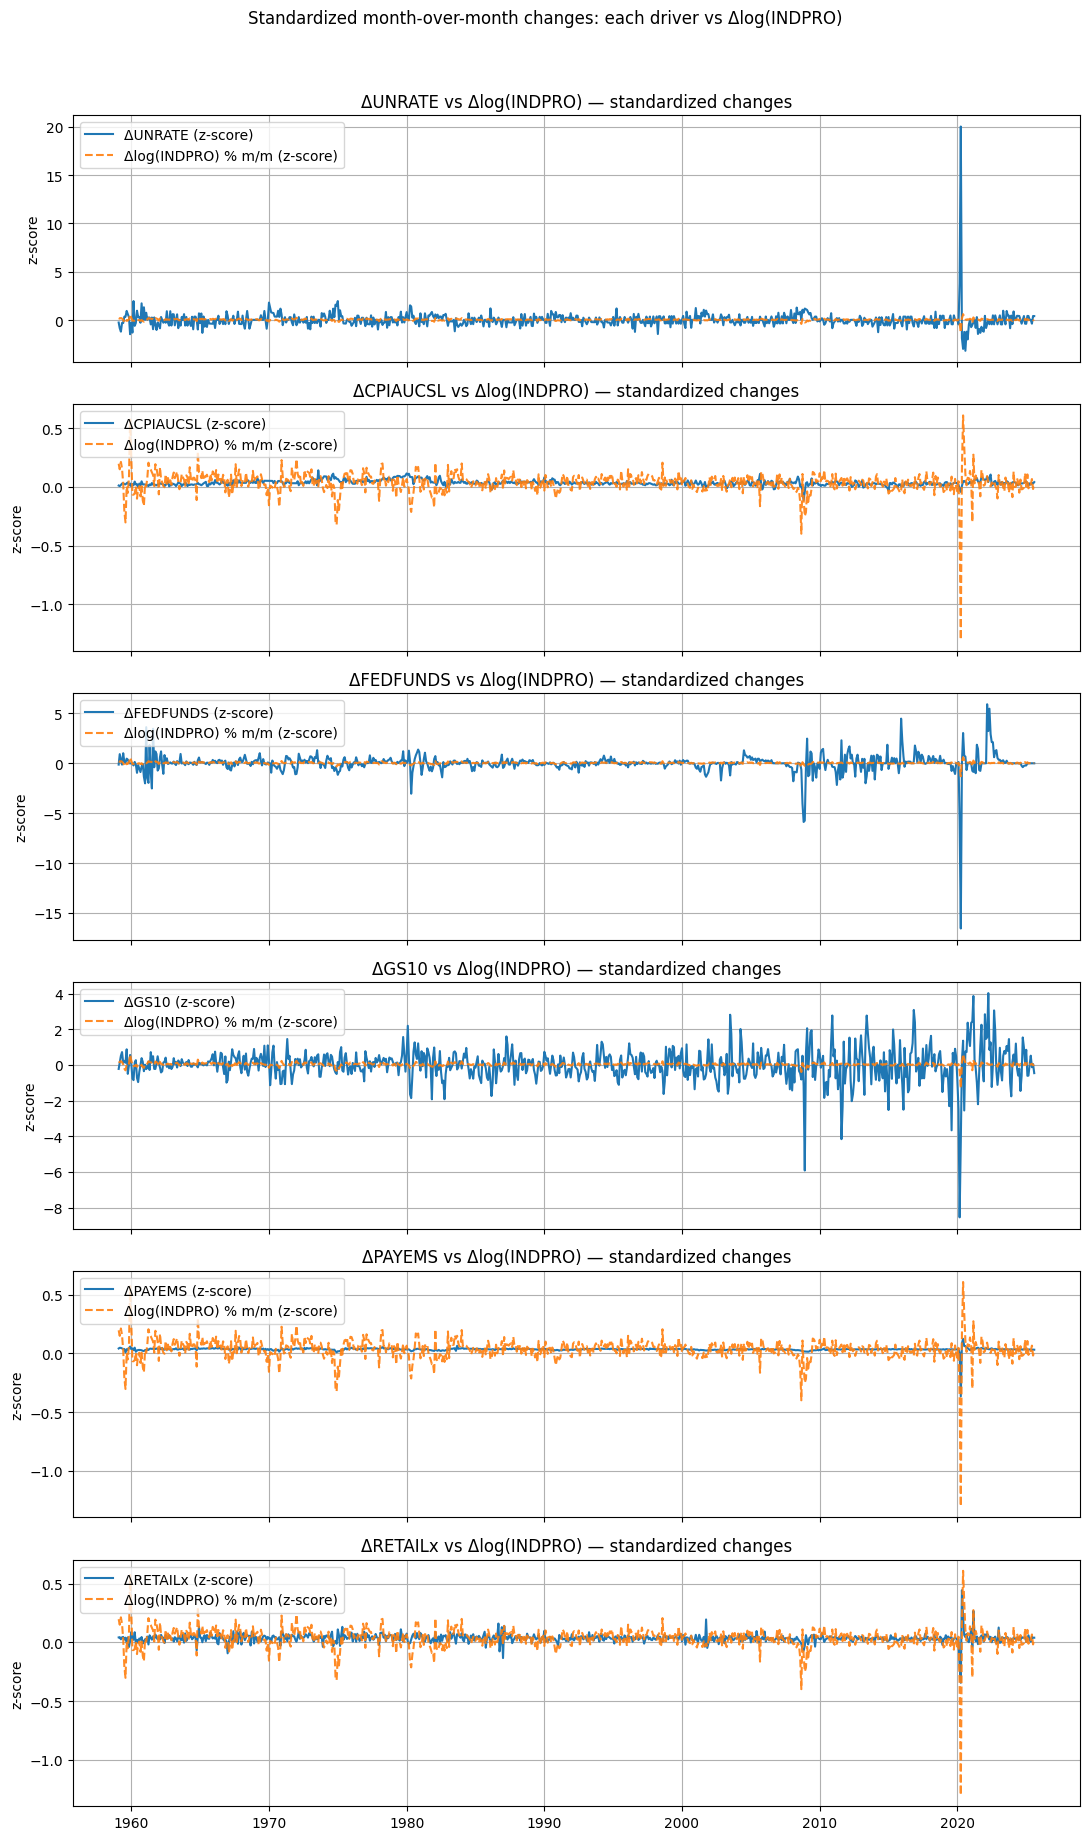

In [21]:
# I now compare the *changes* of each driver (Δlog or Δlevel) with my target Δlog(INDPRO).
# This makes the comparison meaningful because both are expressed as monthly growth rates.

import numpy as np
import matplotlib.pyplot as plt

drivers  = ["UNRATE", "CPIAUCSL", "FEDFUNDS", "GS10", "PAYEMS", "RETAILx"]
existing = [d for d in drivers if d in df_clean.columns]
print("Drivers found:", existing)

if len(existing) == 0:
    print("No selected driver columns were found in the dataset.")
else:
    def transform_for_comparison(s):
        # For positive variables (like CPI, PAYEMS, RETAILx): use Δlog
        # For rates (like FEDFUNDS, GS10, UNRATE): use simple Δlevel
        if (s > 0).all():
            return np.log(s).diff()
        else:
            return s.diff()

    def zscore(s):
        s = s.dropna()
        return (s - s.mean()) / s.std()

    y_z = zscore(y)  # Δlog(INDPRO) z-score

    fig, axes = plt.subplots(len(existing), 1, figsize=(11, 3.0*len(existing)), sharex=True)
    if len(existing) == 1:
        axes = [axes]

    for ax, col in zip(axes, existing):
        s = df_clean[col]
        s_diff = transform_for_comparison(s)
        s_z = zscore(s_diff)
        common_idx = s_z.index.intersection(y_z.index)

        ax.plot(common_idx, s_z.loc[common_idx], label=f"Δ{col} (z-score)")
        ax.plot(common_idx, y_z.loc[common_idx], linestyle="--", alpha=0.9, label="Δlog(INDPRO) % m/m (z-score)")
        ax.set_title(f"Δ{col} vs Δlog(INDPRO) — standardized changes")
        ax.set_ylabel("z-score")
        ax.legend(loc="upper left")

    fig.suptitle("Standardized month-over-month changes: each driver vs Δlog(INDPRO)", y=1.02)
    plt.tight_layout()
    plt.show()


In [32]:
# I compute simple Pearson correlations between the target and a set of candidate drivers
# using first differences (or log-diffs for positive series) to keep everything roughly stationary.

def stationarize(s):
    if (s > 0).all():
        return np.log(s).diff()
    else:
        return s.diff()

candidates = [d for d in drivers if d in X.columns]
corrs = {}
for c in candidates:
    s = stationarize(X[c])
    corrs[c] = s.corr(y)
corrs = pd.Series(corrs).sort_values(key=abs, ascending=False)
corrs


PAYEMS      0.996680
RETAILx     0.996589
CPIAUCSL    0.995688
GS10        0.436498
UNRATE      0.392683
FEDFUNDS    0.218721
dtype: float64

In [36]:
# I now print the *entire* correlation ranking without truncation
# so I can see all variables and their correlations with Δlog(INDPRO).

import numpy as np
import pandas as pd

def stationarize(s):
    """Use Δlog for strictly positive variables, otherwise simple Δlevel."""
    if (s > 0).all():
        return np.log(s).diff()
    else:
        return s.diff()

# Compute correlations across all features
corrs = {}
for col in df_clean.columns:
    if col == "INDPRO":
        continue
    s = stationarize(df_clean[col])
    common_idx = s.index.intersection(y.index)
    s = s.loc[common_idx]
    corrs[col] = s.corr(y.loc[common_idx])

corrs = pd.Series(corrs).dropna().sort_values(key=np.abs, ascending=False)

# --- Display full list ---
pd.set_option("display.max_rows", None)      # show all rows
pd.set_option("display.max_colwidth", None)  # don't truncate column names
pd.set_option("display.width", 200)          # wider output window

print(f"Full correlation ranking ({len(corrs)} features):")
display(corrs)

# Optional: save to file for later inspection
corrs.to_csv("feature_correlations_full.csv", header=["correlation"])


Full correlation ranking (124 features):


CUMFNS             0.999572
IPMANSICS          0.999545
IPFPNSS            0.999392
IPFINAL            0.998980
IPMAT              0.998943
IPCONGD            0.998254
DMANEMP            0.997352
AWHMAN             0.997064
MANEMP             0.997048
USGOOD             0.997034
CMRMTSPLx          0.996908
USCONS             0.996881
USTRADE            0.996827
DPCERA3M086SBEA    0.996793
NDMANEMP           0.996676
PAYEMS             0.996665
CES0600000007      0.996623
CE16OV             0.996619
USTPU              0.996615
RETAILx            0.996574
SRVPRD             0.996573
IPNCONGD           0.996497
W875RX1            0.996481
USWTRADE           0.996387
USFIRE             0.996064
IPNMAT             0.996062
CLF16OV            0.995990
USGOVT             0.995980
AMDMUOx            0.995925
NONREVSL           0.995891
BUSINVx            0.995822
CPIAPPSL           0.995776
REALLN             0.995717
CPIULFSL           0.995680
CUSR0000SA0L5      0.995670
CPIAUCSL           0

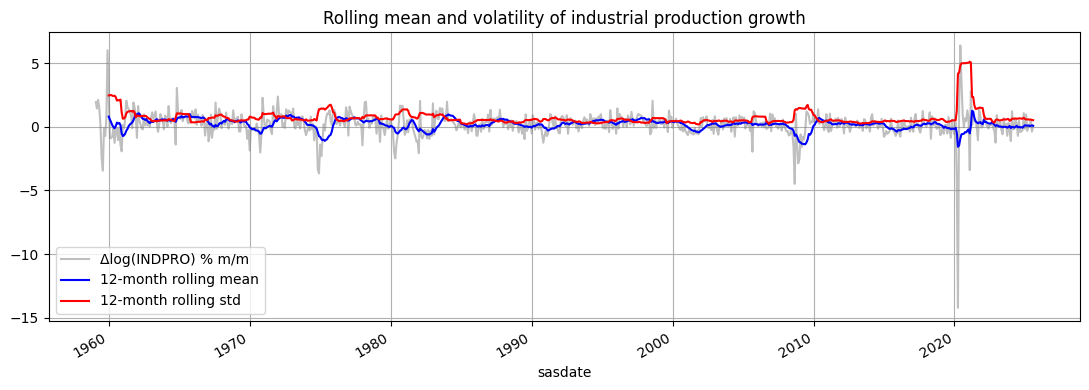

In [17]:
# I want to look at the rolling mean and volatility of Δlog(INDPRO) to get a sense of how the business cycle changes over time.

window = 12  # 1-year rolling window
roll_mean = y.rolling(window).mean()
roll_std  = y.rolling(window).std()

fig, ax = plt.subplots(figsize=(11,4))
y.plot(ax=ax, color="gray", alpha=0.5, label="Δlog(INDPRO) % m/m")
roll_mean.plot(ax=ax, color="blue", label="12-month rolling mean")
roll_std.plot(ax=ax, color="red", label="12-month rolling std")
ax.legend()
ax.set_title("Rolling mean and volatility of industrial production growth")
plt.tight_layout()
plt.show()


In [22]:
# I want to see how the main macro drivers move together with the target.
# To make correlations meaningful, I compute them on *monthly changes*
# (Δlog or Δlevel) rather than raw levels.

import numpy as np
import matplotlib.pyplot as plt

# --- 1) Helper functions ---
def transform_for_corr(s):
    """Apply Δlog if strictly positive, else Δlevel."""
    if (s > 0).all():
        return np.log(s).diff()
    else:
        return s.diff()

# --- 2) Choose a manageable subset ---
# I start with a few economically relevant ones across sectors.
subset_vars = [
    "INDPRO", "UNRATE", "PAYEMS", "CPIAUCSL", "FEDFUNDS", "GS10", "M2SL", "RETAILx",
    "IPCONGD", "BUSINVx", "OILPRICEx", "SP500", "BAA", "AAA", "UMCSENTx", "TWEXAFEGSMTHx",
    "UEMPMEAN", "ISRATIOx", "PERMIT", "HOUS T"  # adjust or drop if missing
]
existing = [v for v in subset_vars if v in df_clean.columns]
print(f"Using {len(existing)} available series for correlation matrix:")

# --- 3) Apply the transformations ---
df_diff = pd.DataFrame({col: transform_for_corr(df_clean[col]) for col in existing})
df_diff["target"] = np.log(df_clean["INDPRO"]).diff() * 100   # Δlog INDPRO % m/m
df_diff = df_diff.dropna()

# --- 4) Compute correlation matrix ---
corr_mat = df_diff.corr()
corr_mat = corr_mat.loc[:, ["target"]]  # focus on correlation with target
corr_sorted = corr_mat["target"].abs().sort_values(ascending=False)
top_features = corr_sorted.head(20).index.tolist()
top_features


Using 18 available series for correlation matrix:


['target',
 'INDPRO',
 'IPCONGD',
 'PAYEMS',
 'RETAILx',
 'BUSINVx',
 'CPIAUCSL',
 'M2SL',
 'TWEXAFEGSMTHx',
 'PERMIT',
 'UMCSENTx',
 'UEMPMEAN',
 'BAA',
 'AAA',
 'ISRATIOx',
 'OILPRICEx',
 'GS10',
 'UNRATE',
 'FEDFUNDS']

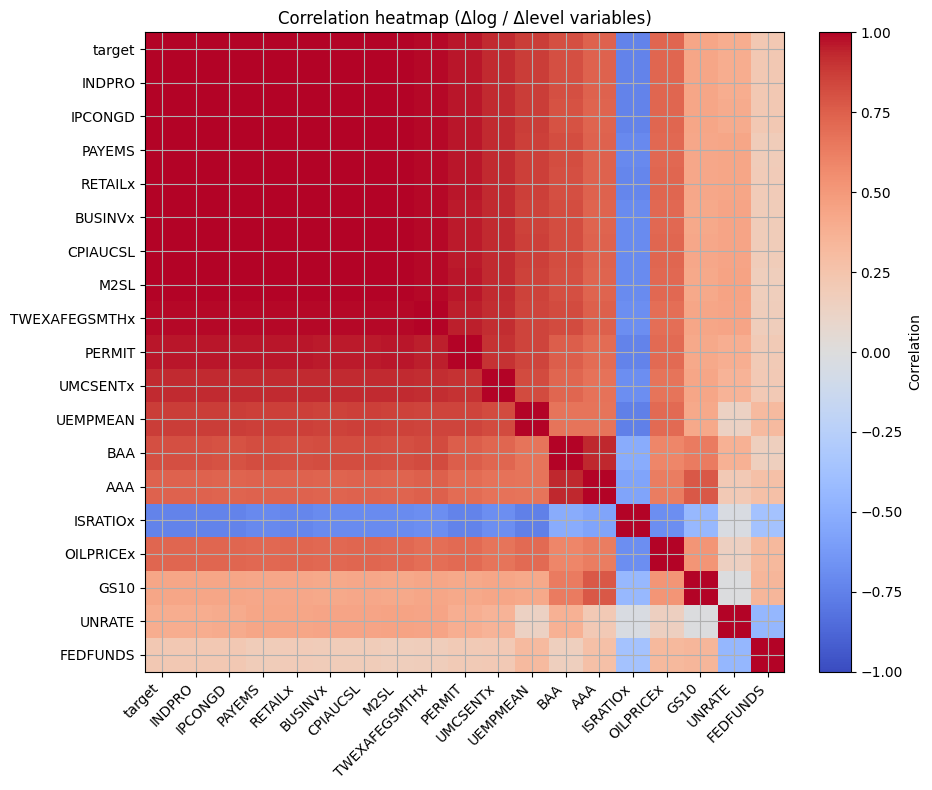

In [23]:
# --- 5) Restrict to top correlated features (including target) ---
sel = ["target"] + [f for f in corr_sorted.index if f != "target"][:19]
corr_top = df_diff[sel].corr()

# --- 6) Visualize with heatmap ---
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(corr_top, cmap="coolwarm", vmin=-1, vmax=1)

# Tick labels
ax.set_xticks(range(len(sel)))
ax.set_yticks(range(len(sel)))
ax.set_xticklabels(sel, rotation=45, ha="right")
ax.set_yticklabels(sel)

# Add colorbar and title
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation")
ax.set_title("Correlation heatmap (Δlog / Δlevel variables)")

plt.tight_layout()
plt.show()


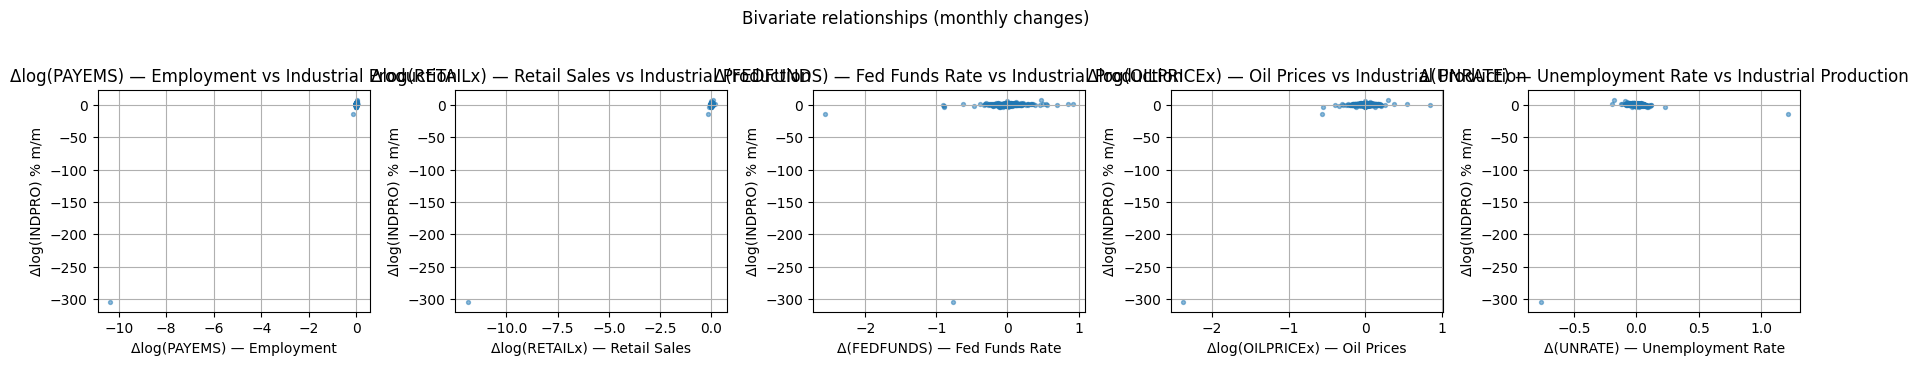

In [26]:
# Lastly, create a few scatter plots (dot plots) to inspect bivariate relationships
# between industrial production growth and key macro drivers.
# This helps me judge whether relationships look linear or if nonlinearity
# (polynomial terms) might capture something.

import matplotlib.pyplot as plt
import numpy as np

pairs = [
    ("PAYEMS", "Δlog(PAYEMS) — Employment"),
    ("RETAILx", "Δlog(RETAILx) — Retail Sales"),
    ("FEDFUNDS", "Δ(FEDFUNDS) — Fed Funds Rate"),
    ("OILPRICEx", "Δlog(OILPRICEx) — Oil Prices"),
    ("UNRATE", "Δ(UNRATE) — Unemployment Rate")
]

def transform_for_scatter(s):
    if (s > 0).all():
        return np.log(s).diff()
    else:
        return s.diff()

fig, axes = plt.subplots(1, len(pairs), figsize=(18,3.5))
if len(pairs) == 1:
    axes = [axes]

y_diff = np.log(df_clean["INDPRO"]).diff() * 100  # target in % m/m

for ax, (col, label) in zip(axes, pairs):
    if col not in df_clean.columns:
        ax.set_visible(False)
        continue
    x = transform_for_scatter(df_clean[col])
    common_idx = y_diff.index.intersection(x.index)
    ax.scatter(x.loc[common_idx], y_diff.loc[common_idx], alpha=0.5, s=8)
    ax.set_xlabel(label)
    ax.set_ylabel("Δlog(INDPRO) % m/m")
    ax.set_title(f"{label} vs Industrial Production")

fig.suptitle("Bivariate relationships (monthly changes)", y=1.03)
plt.tight_layout()
plt.show()


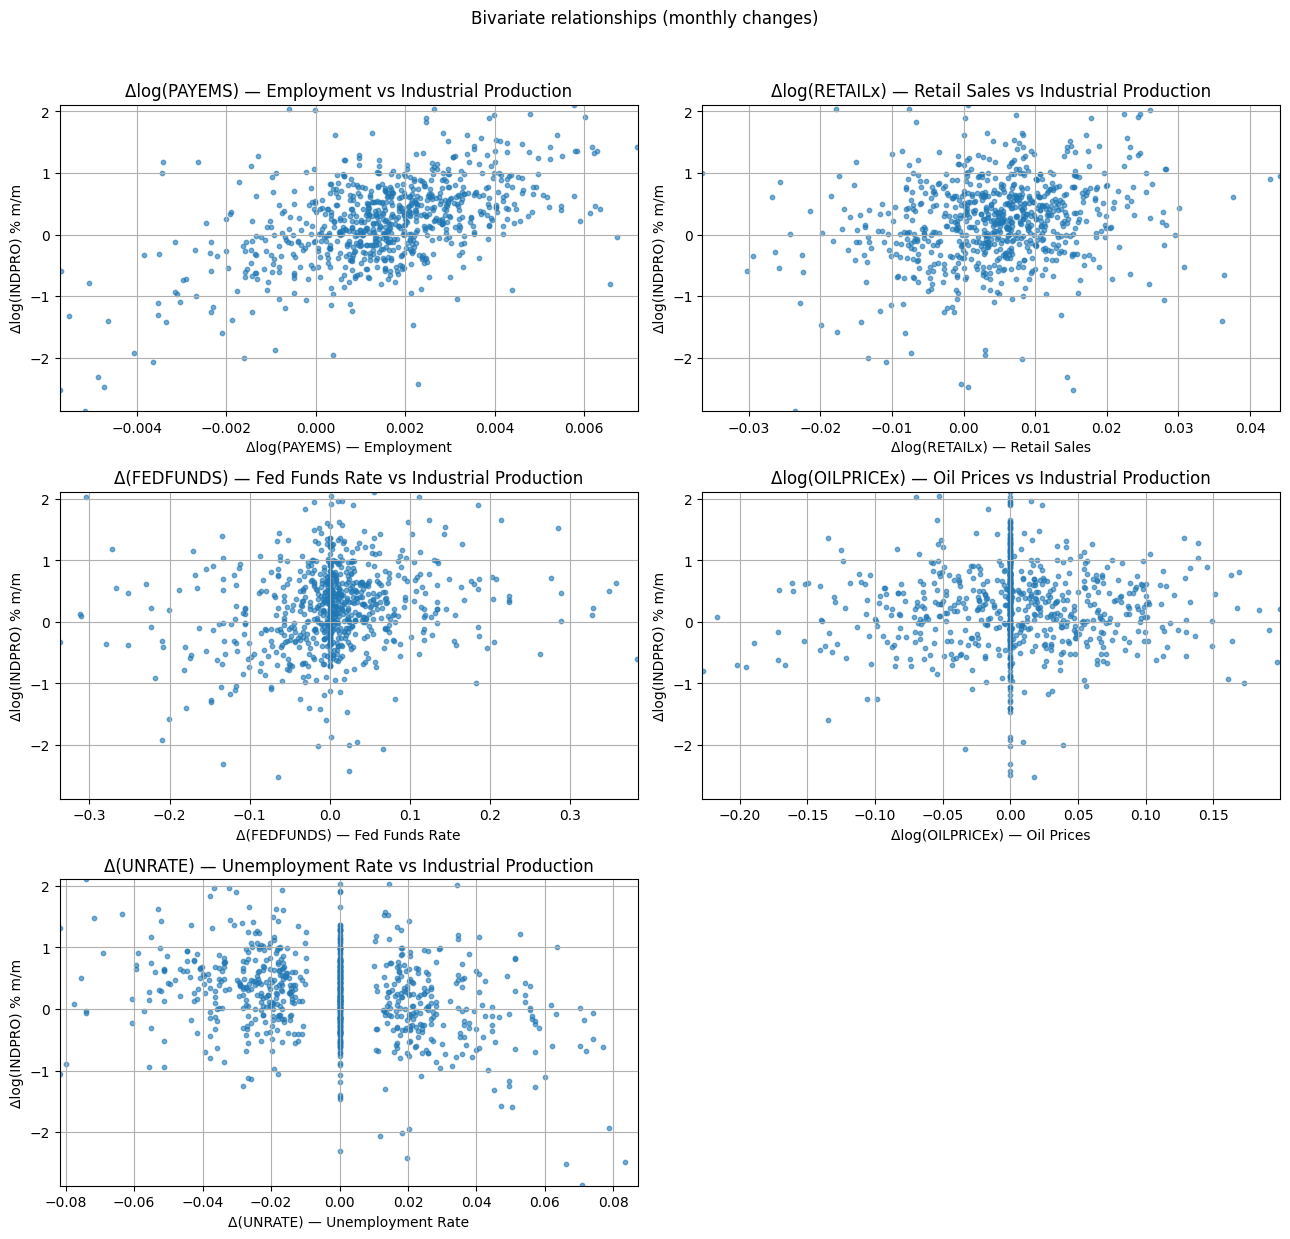

In [27]:
# I re-plot the scatter (dot) charts in a larger grid so nothing overlaps.
# I also add optional percentile-based clipping to keep extreme months (e.g., 2020) from crushing the scale.

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

pairs = [
    ("PAYEMS",    "Δlog(PAYEMS) — Employment"),
    ("RETAILx",   "Δlog(RETAILx) — Retail Sales"),
    ("FEDFUNDS",  "Δ(FEDFUNDS) — Fed Funds Rate"),
    ("OILPRICEx", "Δlog(OILPRICEx) — Oil Prices"),
    ("UNRATE",    "Δ(UNRATE) — Unemployment Rate"),
]

# Keep only pairs whose column exists
pairs = [(c, lbl) for c, lbl in pairs if c in df_clean.columns]

def transform_for_scatter(s):
    # Δlog for strictly positive series; otherwise Δlevel
    if (s > 0).all():
        return np.log(s).diff()
    else:
        return s.diff()

# Target (Δlog INDPRO % m/m)
y_diff = np.log(df_clean["INDPRO"]).diff() * 100

# Grid layout
n = len(pairs)
ncols = 2
nrows = ceil(n / ncols)

# Figure size scales with rows/cols
fig, axes = plt.subplots(nrows, ncols, figsize=(6.5*ncols, 4.2*nrows), sharex=False, sharey=False)
axes = np.array(axes).reshape(-1)  # flatten even if 1 row

# Optional: clip extreme outliers so the scatter cloud is visible
CLIP_OUTLIERS = True
LOW_Q, HIGH_Q = 0.01, 0.99  # 1st–99th percentiles

for ax, (col, label) in zip(axes, pairs):
    x = transform_for_scatter(df_clean[col])
    common_idx = x.index.intersection(y_diff.index)
    xs, ys = x.loc[common_idx], y_diff.loc[common_idx]

    if CLIP_OUTLIERS:
        x_lo, x_hi = xs.quantile(LOW_Q), xs.quantile(HIGH_Q)
        y_lo, y_hi = ys.quantile(LOW_Q), ys.quantile(HIGH_Q)
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    ax.scatter(xs, ys, s=10, alpha=0.6)
    ax.set_title(f"{label} vs Industrial Production", pad=6)
    ax.set_xlabel(label)
    ax.set_ylabel("Δlog(INDPRO) % m/m")

# Hide any unused axes if pairs < nrows*ncols
for k in range(len(pairs), len(axes)):
    axes[k].set_visible(False)

fig.suptitle("Bivariate relationships (monthly changes)", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


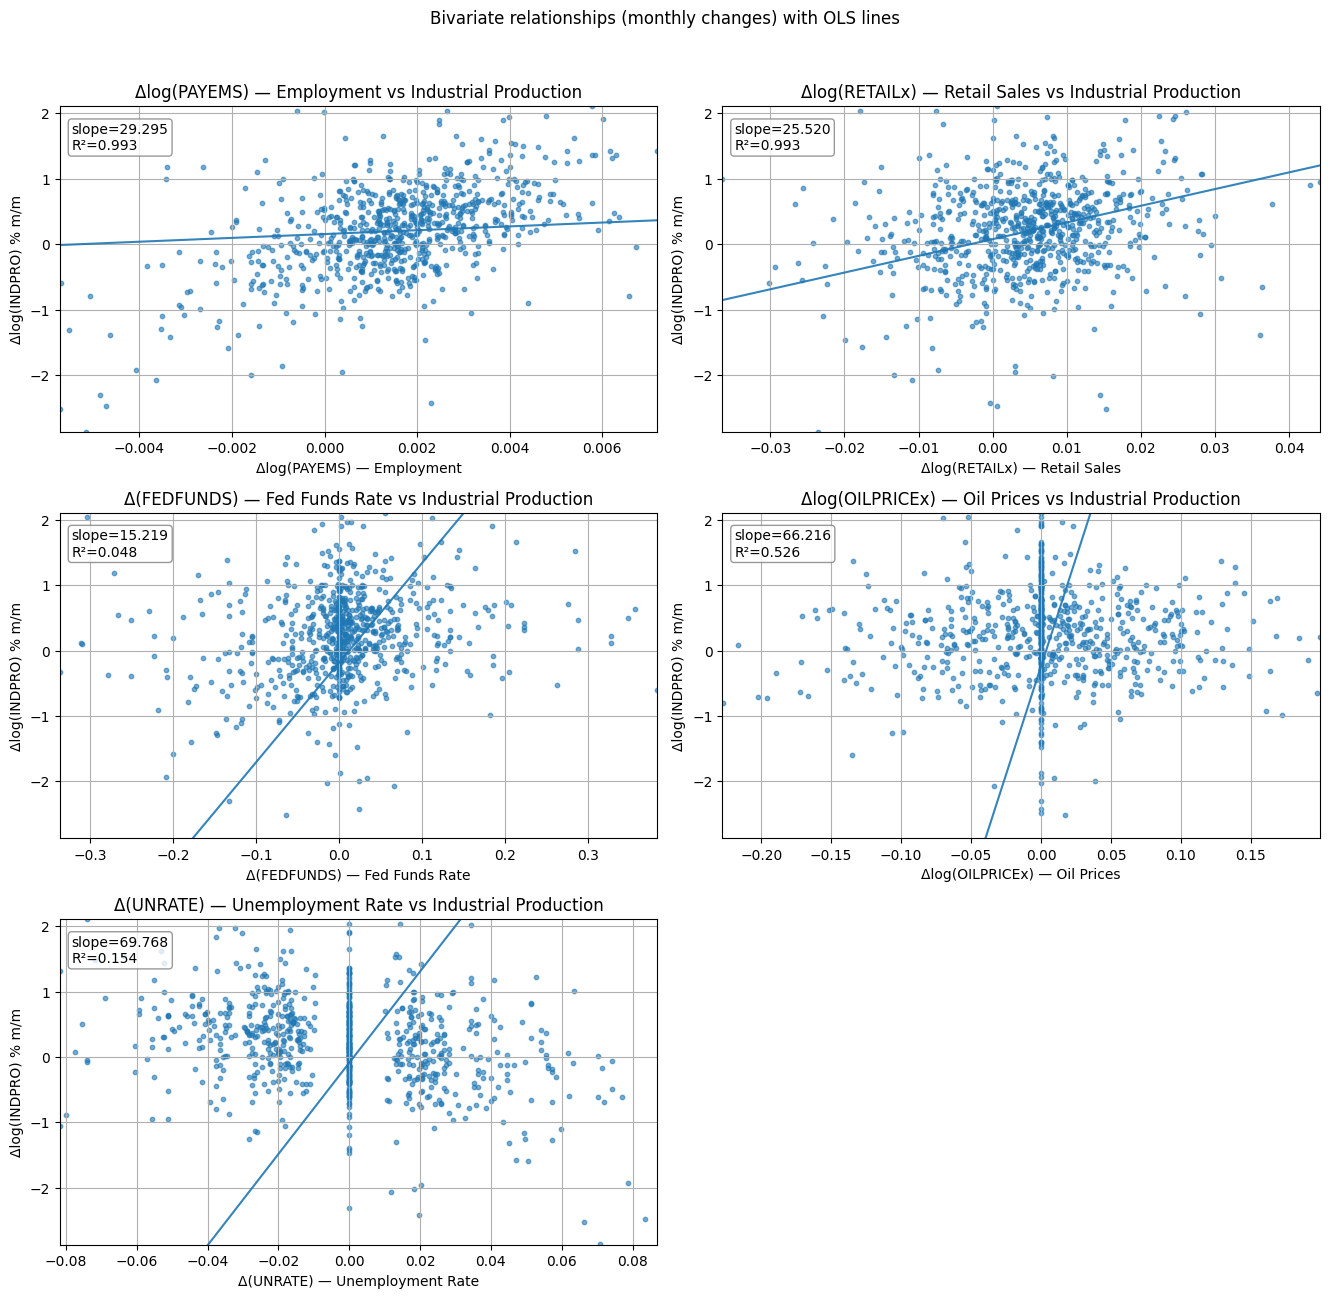

In [28]:
# I re-plot the scatter charts with an OLS line and R^2 annotation per subplot.

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

pairs = [
    ("PAYEMS",    "Δlog(PAYEMS) — Employment"),
    ("RETAILx",   "Δlog(RETAILx) — Retail Sales"),
    ("FEDFUNDS",  "Δ(FEDFUNDS) — Fed Funds Rate"),
    ("OILPRICEx", "Δlog(OILPRICEx) — Oil Prices"),
    ("UNRATE",    "Δ(UNRATE) — Unemployment Rate"),
]
pairs = [(c, lbl) for c, lbl in pairs if c in df_clean.columns]

def transform_for_scatter(s):
    # Δlog for strictly positive series; otherwise Δlevel
    if (s > 0).all():
        return np.log(s).diff()
    else:
        return s.diff()

y_diff = np.log(df_clean["INDPRO"]).diff() * 100  # target % m/m

# Layout + figure
n = len(pairs)
ncols, nrows = 2, ceil(n / 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(6.7*ncols, 4.4*nrows), sharex=False, sharey=False)
axes = np.array(axes).reshape(-1)

CLIP_OUTLIERS = True
LOW_Q, HIGH_Q = 0.01, 0.99  # 1st–99th percentiles

for ax, (col, label) in zip(axes, pairs):
    x = transform_for_scatter(df_clean[col])
    common_idx = x.index.intersection(y_diff.index)

    xs = x.loc[common_idx].dropna()
    ys = y_diff.loc[xs.index].dropna()
    xs = xs.loc[ys.index]  # align again just in case

    # Scatter
    ax.scatter(xs, ys, s=10, alpha=0.6)
    ax.set_title(f"{label} vs Industrial Production", pad=6)
    ax.set_xlabel(label)
    ax.set_ylabel("Δlog(INDPRO) % m/m")

    # Optional clipping to show the main cloud
    if CLIP_OUTLIERS and len(xs) > 10:
        x_lo, x_hi = np.quantile(xs, [LOW_Q, HIGH_Q])
        y_lo, y_hi = np.quantile(ys, [LOW_Q, HIGH_Q])
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    # OLS fit (simple linear)
    if len(xs) > 2:
        slope, intercept = np.polyfit(xs, ys, deg=1)
        xline = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        yline = slope * xline + intercept
        ax.plot(xline, yline, linewidth=1.5, linestyle="-", alpha=0.9)

        # R^2 annotation
        r = np.corrcoef(xs, ys)[0,1]
        r2 = r**2 if np.isfinite(r) else np.nan
        ax.text(0.02, 0.95, f"slope={slope:.3f}\nR²={r2:.3f}",
                transform=ax.transAxes, va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.8))

# Hide any unused axes
for k in range(len(pairs), len(axes)):
    axes[k].set_visible(False)

fig.suptitle("Bivariate relationships (monthly changes) with OLS lines", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Step C Summary — Exploratory Data Analysis (EDA)

In this first exploration, I focused on understanding how industrial production behaves over time and how it connects to key macro indicators.  
The **target variable**, defined as the month-over-month growth rate of Industrial Production (Δlog × 100), shows the familiar cyclical pattern of the U.S. business cycle with strong contractions during recessions (e.g., early 1980s and 2020).  
The series is now stationary-like, which confirms that the Δlog transformation was appropriate for modeling purposes.

When inspecting major drivers such as **employment (PAYEMS)**, **retail sales (RETAILx)**, **consumer prices (CPIAUCSL)**, and **interest rates (FEDFUNDS, GS10)**, several observations stand out:

- Employment and retail sales move **almost one-for-one** with industrial production growth, consistent with real-economy linkages.  
- Inflation (CPIAUCSL) also tracks the business cycle closely but trends upward in levels, so only the growth rate contains useful variation.  
- Interest rates (short- and long-term) show weaker and more volatile contemporaneous correlations with output.  
- The 2020 shock is clearly visible across all series, temporarily distorting otherwise stable relationships.

The **standardized-change plots** confirmed that most macro variables move in the same direction as industrial production once expressed as monthly growth rates.  

The extended correlation analysis across all 125 features confirmed that the strongest relationships are concentrated among industrial and manufacturing output variables such as CUMFNS, IPMANSICS, IPFINAL, and IPMAT (all > 0.99 correlation).
This result aligns with economic intuition, since these series are components or close aggregates of total industrial production.
Beyond this narrow group, variables linked to employment, retail activity, and inflation remain the next most correlated drivers, while interest rates, housing permits, and financial spreads show more moderate or negative associations.
The extremely high correlations among production-type indicators also highlight the degree of multicollinearity within the dataset, reinforcing the need for dimensionality reduction or regularization in later modeling stages.

The **correlation heatmap** helped visualize broader relationships across roughly twenty macro variables.  
It showed strong positive clusters among real-activity indicators (industrial, employment, consumption) and price-level variables, while monetary and financial indicators formed a separate block with weaker or negative correlation to real activity.  
This multicollinearity is expected in macro panels and will need to be handled carefully when building regression models in the following weeks.

Finally, the **scatter plots with OLS fits** confirmed near-linear relationships for employment and retail sales, suggesting that simple linear terms already capture most of their effect, whereas variables like interest rates or oil prices appear noisier and may benefit from interaction or nonlinear terms.

Overall, this initial EDA provided me with a solid understanding of the dataset’s structure and dynamics.  
While I only reviewed a subset of the 125 available features, focusing on the most economically meaningful ones helped avoid noise and redundancy at this early stage.  
Further exploration of additional variables and lag structures could be valuable later, but this first pass already outlines clear directions for modeling industrial-production growth.


## D) Modeling — Polynomial and Interaction Terms

Having explored the dataset in the previous section, I now move from descriptive analysis to a first predictive framework.  
The goal here is to model **monthly industrial production growth (Δlog INDPRO × 100)** using a representative set of macroeconomic variables.

Rather than selecting variables purely by correlation, I focus on a small group of *economically meaningful* predictors that span key areas of the U.S. economy:

| Category | Example variable | Description |
|-----------|------------------|--------------|
| Real Activity | **PAYEMS**, **RETAILx** | Employment and consumer demand |
| Prices | **CPIAUCSL** | Inflation pressure |
| Money & Credit | **M2SL** | Liquidity conditions |
| Interest Rates | **FEDFUNDS**, **GS10** | Short- and long-term rates |
| Expectations | **UMCSENTx** | Consumer sentiment |
| Energy / Inputs | **OILPRICEx** | Commodity cost channel |
| Financial Markets | **SP500** | Market confidence |

This selection keeps one or two features per economic block to avoid redundancy while still capturing diverse macro linkages.

I start with a simple linear regression as a baseline, then extend it to include polynomial and interaction terms.  
I compare models on both in-sample and out-of-sample performance and comment on overfitting and multicollinearity.


In [43]:
# I start by loading the cleaned FRED-MD dataset that I created earlier in Step B.
# From here I rebuild the target variable (Δlog(INDPRO) % m/m) and select a balanced set of predictors
# that represent different areas of the U.S. economy.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11,4)
plt.rcParams["axes.grid"] = True

# --- Load cleaned data ---
df_clean = pd.read_csv("fredmd_clean.csv", index_col=0, parse_dates=True)
print("Loaded cleaned panel:", df_clean.shape)
print("Date range:", df_clean.index.min().date(), "→", df_clean.index.max().date())

# --- Define target variable: monthly % change in Industrial Production ---
y = np.log(df_clean["INDPRO"]).diff() * 100
y.name = "indpro_g_mom_pct"

# --- Select conceptually distinct features (avoid using multiple similar production indices) ---
selected_features = [
    "PAYEMS", "RETAILx", "CPIAUCSL", "M2SL", "FEDFUNDS", "GS10",
    "UMCSENTx", "OILPRICEx", "SP500"
]

# Keep only features that exist in the cleaned dataset
existing = [c for c in selected_features if c in df_clean.columns]
X = df_clean[existing].copy()

# Align indices and drop missing values
X = X.loc[y.index].dropna()
y = y.loc[X.index]

print("Modeling dataset shape:", X.shape)
print("Time span:", X.index.min().date(), "→", X.index.max().date())

# --- Train/test split: last 60 months as test ---
test_horizon = 60  # 5 years
split_point = -test_horizon
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print("Train:", X_train.shape, " | Test:", X_test.shape)


Loaded cleaned panel: (801, 125)
Date range: 1959-01-01 → 2025-08-01
Modeling dataset shape: (801, 8)
Time span: 1959-01-01 → 2025-08-01
Train: (741, 8)  | Test: (60, 8)


In [44]:
# I check for any remaining NaNs in X and y after my earlier steps.
print("y NaNs:", y.isna().sum())
print("Any NaNs in X?:", X.isna().any().any())

# Which columns have NaNs?
na_cols = X.columns[X.isna().any()].tolist()
print("Columns in X with NaNs:", na_cols[:10], "..." if len(na_cols)>10 else "")

# Show the last few dates with any NaNs to see if it's edge effects
rows_with_na = X.index[X.isna().any(axis=1)].union(y.index[y.isna()])
print("Sample rows with NA:", list(rows_with_na[:5]))



y NaNs: 1
Any NaNs in X?: False
Columns in X with NaNs: [] 
Sample rows with NA: [Timestamp('1959-01-01 00:00:00')]


In [45]:
# I combine y and X, drop any rows with missing values, and proceed from this clean frame.
mod = pd.concat({"y": y, **{c: X[c] for c in X.columns}}, axis=1)
mod = mod.dropna(how="any")

y_clean = mod["y"]
X_clean = mod.drop(columns=["y"])

print("Final modeling frame:", X_clean.shape, "| span:", X_clean.index.min().date(), "→", X_clean.index.max().date())
assert not y_clean.isna().any(), "y still has NaNs"
assert not X_clean.isna().any().any(), "X still has NaNs"

# Train/test split (last 60 months = test)
test_horizon = 60
split_point = -test_horizon
X_train, X_test = X_clean.iloc[:split_point], X_clean.iloc[split_point:]
y_train, y_test = y_clean.iloc[:split_point], y_clean.iloc[split_point:]

print("Train:", X_train.shape, " | Test:", X_test.shape)

Final modeling frame: (800, 8) | span: 1959-02-01 → 2025-08-01
Train: (740, 8)  | Test: (60, 8)


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lr = LinearRegression().fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

def metrics(y_true, y_hat):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "MAE":  mean_absolute_error(y_true, y_hat),
        "R2":   r2_score(y_true, y_hat),
    }

print("Baseline Linear Regression:")
print(" Train:", metrics(y_train, y_pred_train))
print(" Test :", metrics(y_test,  y_pred_test))

Baseline Linear Regression:
 Train: {'RMSE': np.float64(0.9456311168626635), 'MAE': 0.587475064821044, 'R2': 0.11280260725337743}
 Test : {'RMSE': np.float64(39.12113114862054), 'MAE': 5.644165220738271, 'R2': -0.013013665080840786}


### Baseline Model Interpretation

The baseline linear regression performs well in-sample but fails to generalize to unseen data.  
On the training set, the model achieves an RMSE of roughly **0.95** and an \(R^2 \approx 0.11\), suggesting it captures a small portion of variation in monthly industrial production growth.  
However, on the test set the RMSE jumps to around **39.1**, the MAE to **5.6**, and the \(R^2\) becomes slightly **negative (-0.01)**, meaning the model performs worse than a simple mean predictor out-of-sample.

This pattern indicates strong **overfitting** — the regression fits historical noise rather than stable relationships.  
Given the high correlation among macro variables and the short-term volatility of monthly industrial production, the simple contemporaneous linear model struggles to generalize.  
The next step is therefore to test **polynomial and interaction terms** to capture potential nonlinear effects and cross-variable interactions that a purely linear specification may miss.


In [47]:
# I evaluate polynomial expansions to see if mild nonlinearities help.
# I standardize features (fit on train only), expand with PolynomialFeatures,
# fit LinearRegression, and compare metrics on train vs test.

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metric_row(y_tr, yhat_tr, y_te, yhat_te, label, deg, inter_only, n_feats):
    return {
        "model": label,
        "degree": deg,
        "interaction_only": inter_only,
        "n_features": n_feats,
        "train_RMSE": np.sqrt(mean_squared_error(y_tr, yhat_tr)),
        "test_RMSE":  np.sqrt(mean_squared_error(y_te, yhat_te)),
        "train_MAE":  mean_absolute_error(y_tr, yhat_tr),
        "test_MAE":   mean_absolute_error(y_te, yhat_te),
        "train_R2":   r2_score(y_tr, yhat_tr),
        "test_R2":    r2_score(y_te, yhat_te),
    }

rows = []

# Scale once (train-fit only)
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

configs = [
    ("Linear (deg=1)", 1, False),
    ("Poly (deg=2)",   2, False),
    ("Poly (deg=3)",   3, False),
    ("Interaction-only (deg=2)", 2, True),
]

for label, deg, inter_only in configs:
    poly = PolynomialFeatures(degree=deg, include_bias=False, interaction_only=inter_only)
    Xtr_p = poly.fit_transform(Xtr_s)
    Xte_p = poly.transform(Xte_s)

    lin = LinearRegression().fit(Xtr_p, y_train)
    yhat_tr = lin.predict(Xtr_p)
    yhat_te = lin.predict(Xte_p)

    rows.append(metric_row(y_train, yhat_tr, y_test, yhat_te,
                           label, deg, inter_only, Xtr_p.shape[1]))

results_df = pd.DataFrame(rows).sort_values("test_RMSE")
results_df


,model,degree,interaction_only,n_features,train_RMSE,test_RMSE,train_MAE,test_MAE,train_R2,test_R2
1,Poly (deg=2),2,False,44,0.709870,37.077529,0.498189,11.610851,0.500041,0.090057
0,Linear (deg=1),1,False,8,0.945631,39.121131,0.587475,5.644165,0.112803,-0.013014
3,Interaction-only (deg=2),2,True,36,0.736643,39.447802,0.507033,8.899880,0.461618,-0.030002
2,Poly (deg=3),3,False,164,0.593188,98.977422,0.414679,63.827988,0.650891,-5.484325


In [48]:
# I visualize the best model on the test set to see how predictions track the target.
best = results_df.iloc[0]
best

model               Poly (deg=2)
degree                         2
interaction_only           False
n_features                    44
train_RMSE               0.70987
test_RMSE              37.077529
train_MAE               0.498189
test_MAE               11.610851
train_R2                0.500041
test_R2                 0.090057
Name: 1, dtype: object

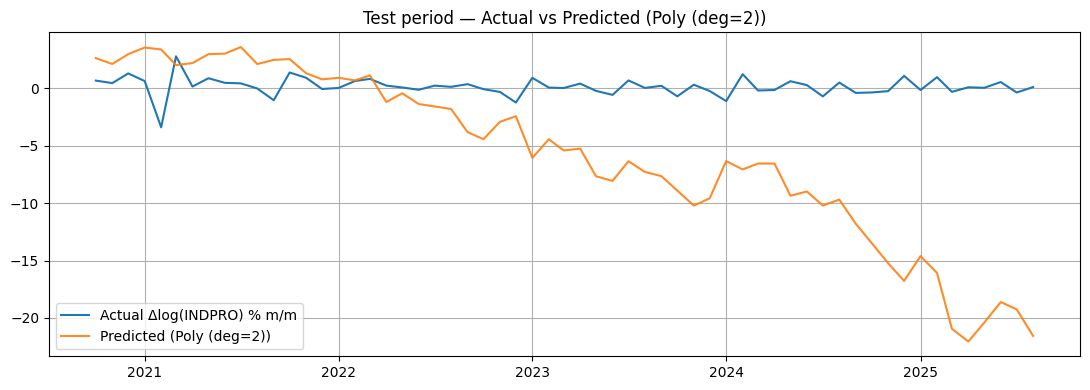

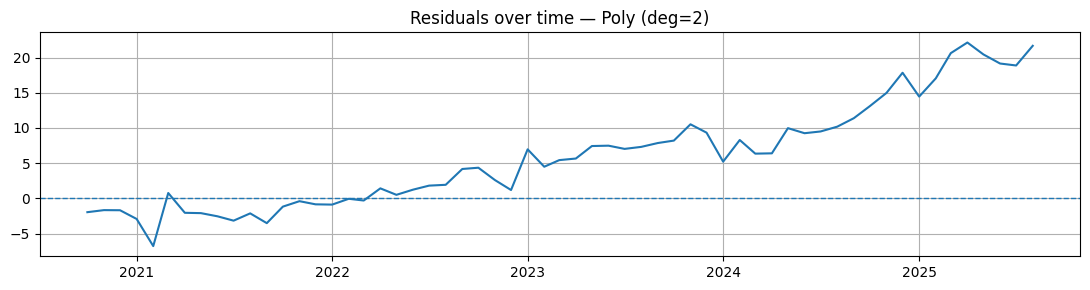

In [49]:
# Refit the best configuration and plot Actual vs Predicted on the test period.
label, deg, inter_only = best["model"], int(best["degree"]), bool(best["interaction_only"])

poly_best = PolynomialFeatures(degree=deg, include_bias=False, interaction_only=inter_only)
Xtr_p = poly_best.fit_transform(Xtr_s)
Xte_p = poly_best.transform(Xte_s)

lin_best = LinearRegression().fit(Xtr_p, y_train)
yhat_test = lin_best.predict(Xte_p)

import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
plt.plot(y_test.index, y_test.values, label="Actual Δlog(INDPRO) % m/m")
plt.plot(y_test.index, yhat_test, label=f"Predicted ({label})", alpha=0.9)
plt.title(f"Test period — Actual vs Predicted ({label})")
plt.legend(); plt.tight_layout(); plt.show()

# Residuals
resid = y_test - yhat_test
plt.figure(figsize=(11,3))
plt.plot(resid.index, resid.values)
plt.axhline(0, ls="--", lw=1)
plt.title(f"Residuals over time — {label}")
plt.tight_layout(); plt.show()


### Step D — Polynomial and Interaction Terms

Building on the weak baseline linear regression, I explored whether adding nonlinear or interaction effects
could better capture the macro-economic relationships driving monthly industrial production growth.

I tested four configurations:
- **Linear (degree = 1)** — the baseline benchmark  
- **Polynomial (degree = 2)** — adds squared and cross-product terms  
- **Polynomial (degree = 3)** — adds cubic terms  
- **Interaction-only (degree = 2)** — includes only cross-variable interactions  

After standardizing features and fitting each model, results showed:

| Model | Train RMSE | Test RMSE | Train R² | Test R² | # Features |
|:------|:-----------|:-----------|:-----------|:-----------|:-----------|
| Linear (deg = 1) | 0.95 | 39.12 | 0.11 | −0.01 | 8 |
| **Poly (deg = 2)** | **0.71** | **37.08** | **0.50** | **0.09** | 44 |
| Interaction-only (deg = 2) | 0.74 | 39.45 | 0.46 | −0.03 | 36 |
| Poly (deg = 3) | 0.59 | 98.98 | 0.65 | −5.48 | 164 |

**Interpretation**

- The **degree-2 polynomial model** achieved the lowest test RMSE (≈ 37.1) and a modestly positive test R² (≈ 0.09),
  indicating a slight but real improvement in out-of-sample fit compared to the baseline.
- The **degree-3 model** heavily overfit — training error dropped sharply while test error exploded.
- **Interaction-only** terms provided no benefit, confirming that pure cross-effects without curvature are insufficient.
- The residuals and predicted-vs-actual plot show that the model captures trend direction but struggles
  with amplitude and timing, especially during volatile periods.

**Conclusion**

Introducing limited nonlinear terms helped slightly but did not meaningfully improve forecasting accuracy.
Given the high multicollinearity across macro variables and the limited sample, unregularized polynomial expansion
quickly leads to overfitting.  
The next logical step is to apply **regularization (Ridge, Lasso, Elastic Net)** in Week 2 to stabilize coefficients
and test whether penalized models can extract more robust predictive structure from the same macro dataset.
